In [2]:
import gzip
import math
import os
import re
import sys
from enum import Enum
from io import StringIO
from time import time

import matplotlib.pyplot as pyplot
import numpy
import pandas
import requests
import tensorflow
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2022-07-06 19:07:12.894596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 19:07:12.894723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
DATASET_COLUMNS_FILE = os.path.join("data", "kddcup1999_columns.txt")

if not os.path.exists(DATASET_COLUMNS_FILE):
    with requests.get("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names") as request:
        with open(DATASET_COLUMNS_FILE, 'wb') as file:
            file.write(request.content)

In [8]:
ColumnType = Enum('ColumnType', 'SYMBOLIC CONTINUOUS')
column_types = {}

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[1:]:
    match = column_regex.match(column_type)
    column_types[match.group("column_name")] = ColumnType[match.group("data_type").upper()]

In [9]:
DATASET_URL = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz"
DATASET_FILE = os.path.join("data", "kddcup1999.csv")

# download dataset if not already cached
if not os.path.exists(DATASET_FILE):
    with requests.get(DATASET_URL) as response:
        if response.status_code != 200:
            raise RuntimeError(f"failed to download dataset: {DATASET_URL}")
        # decompress content
        with open(DATASET_FILE, 'wb') as file:
            file.write(gzip.decompress(response.content))

In [10]:
dataframe = pandas.read_csv(
    # file to import from
    DATASET_FILE,
    # important to specify the CSV file contains no headers
    # otherwise, the first record is interpreted as a header
    header=None,
)
dataframe.columns = [*column_types.keys(), "outcome"]

pandas.set_option('display.max_rows', 10)
dataframe

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


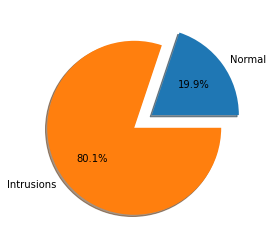

In [11]:
type_frequencies = dataframe['outcome'].value_counts()
normal_frequency = type_frequencies['normal.']
intrusion_frequency = sum([count for outcome_type, count in type_frequencies.iteritems() if outcome_type != 'normal.'])

figure = pyplot.figure()
pyplot.pie(
    [normal_frequency, intrusion_frequency],
    labels=["Normal", "Intrusions"],
    explode=[0, .25],
    autopct='%1.1f%%',
    shadow=True,
)
pyplot.show()

In [12]:
intrusion_frequencies=type_frequencies.drop(labels=["normal."])

pandas.set_option('display.max_rows', None)
display(
    pandas.DataFrame(
        intrusion_frequencies.values,
        columns=['frequency'],
        index=[intrusion_name[:-1] for intrusion_name in intrusion_frequencies.index]
    ).sort_values(by="frequency", ascending=False)
)
pandas.set_option('display.max_rows', 10)

,frequency
smurf,2807886
neptune,1072017
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979
pod,264


In [13]:
unique_dataframe = dataframe.drop_duplicates()
print(f"Dropped {len(dataframe) - len(unique_dataframe):,}/{len(dataframe):,} (-{100*(len(dataframe) - len(unique_dataframe))/len(dataframe):.2f}%) duplicate records")

Dropped 3,823,439/4,898,431 (-78.05%) duplicate records


In [14]:
encoded_dataframe = pandas.get_dummies(
    unique_dataframe,
    # all categorical columns
    columns=[column_name for column_name, column_type in column_types.items() if column_type == ColumnType.SYMBOLIC],
    # drop original column
    drop_first=True,
)

pandas.set_option('display.max_rows', 10)
encoded_dataframe

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_1,logged_in_1,is_host_login_1,is_guest_login_1
0,0,215,45076,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,162,4528,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,236,1228,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,233,2032,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,239,486,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,212,2288,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4898427,0,219,236,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4898428,0,218,3610,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4898429,0,219,1234,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [60]:
TRAINING_PROPORTION = .25
TESTING_PROPORTION = .70
VALIDATION_PROPORTION = .05
PRNG_SEED = numpy.random.seed()
assert TRAINING_PROPORTION + TESTING_PROPORTION + VALIDATION_PROPORTION <= 1.0

partitions = {'train': pandas.DataFrame()}

remaining_dataframe = pandas.DataFrame()
grouped_outcomes = encoded_dataframe.groupby('outcome')
maximum_per_class = math.ceil((TRAINING_PROPORTION * len(grouped_outcomes.groups['normal.'])) / (len(grouped_outcomes.groups.keys()) - 1))
for key in grouped_outcomes.groups.keys():
    group = grouped_outcomes.get_group(key)

    training, remaining = train_test_split(
        group,
        shuffle=True,
        train_size=min(math.ceil(TRAINING_PROPORTION * len(group.index)), maximum_per_class) if key != "normal." else TRAINING_PROPORTION,
    )
    if key != "normal.":
        training = training.sample(n=maximum_per_class, replace=True, random_state=PRNG_SEED)
    partitions['train'] = partitions['train'].append(training)
    remaining_dataframe = remaining_dataframe.append(remaining)

partitions['test'], partitions['validate'] = train_test_split(
    remaining_dataframe,
    shuffle=True,
    train_size=TESTING_PROPORTION / (1 - TRAINING_PROPORTION),
    test_size=VALIDATION_PROPORTION / (1 - TRAINING_PROPORTION),
)
train_size=TESTING_PROPORTION / (1 - TRAINING_PROPORTION)
test_size=VALIDATION_PROPORTION / (1 - TRAINING_PROPORTION)
print(train_size)
print(test_size)

/tmp/ipykernel_26238/138214546.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partitions['train'] = partitions['train'].append(training)
/tmp/ipykernel_26238/138214546.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  remaining_dataframe = remaining_dataframe.append(remaining)
/tmp/ipykernel_26238/138214546.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partitions['train'] = partitions['train'].append(training)
/tmp/ipykernel_26238/138214546.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  remaining_dataframe = remaining_dataframe.append(remaining)
/tmp/ipykernel_26238/138214546.py:22: FutureWarning: The frame.append 

0.9333333333333332
0.06666666666666667


In [18]:
pandas.set_option("mode.chained_assignment", None)

for column_name, column_type in column_types.items():
    if column_type == ColumnType.CONTINUOUS:
        mean = partitions['train'][column_name].mean()
        std = partitions['train'][column_name].std()
        if std == 0:
            std = 1

        for partition_name, dataframe in partitions.items():
            dataframe.loc[:,column_name] = (dataframe[column_name] - mean) / std

In [19]:
tf_input = {
    partition_name: dataframe.drop("outcome", axis="columns").reset_index(drop=True)
    for partition_name, dataframe in partitions.items()
}


In [20]:
tf_output = {
    partition_name: pandas.DataFrame(
        # one-hot-encode normal vs intrusions for binary classification
        [
            [1, 0] if outcome == 'normal.' else [0, 1]
            for outcome in dataframe[['outcome']].to_numpy()
        ],
        # binary classification of connection
        columns=['normal', 'intrusion'],
    )
    for partition_name, dataframe in partitions.items()
}

In [21]:
# build model
model = Sequential(
    [
        Dense(128, input_dim=tf_input['train'].shape[1]),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(tf_output['train'].shape[1], activation='softmax')
    ],
    name="kdd_cup_1999_classification"
)
# set optimizer settings
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# print model summary
model.summary()

Model: "kdd_cup_1999_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               15360     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 


2022-07-04 18:19:56.801543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-04 18:19:56.802329: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-04 18:19:56.803264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nitro): /proc/driver/nvidia/version does not exist
2022-07-04 18:19:56.809695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 26,258
Trainable params: 26,258
Non-trainable params: 0
_________________________________________________________________


In [55]:
start_time = time()

# store standard out stream
original_stdout = sys.stdout
# replace standard out for intercepting model training logs
sys.stdout = captured_stdout = StringIO()

try:

    # make temporary directory for saved model
    if not os.path.exists("temp"):
        os.mkdir("temp")

    # perform model training
    history = model.fit(
        # training data
        tf_input['train'], tf_output['train'],
        # use test data to validate losses, but not for training
        validation_data=(tf_input['validate'], tf_output['validate']),
        callbacks=[
            # patience: number of epochs with no improvement after which training will be stopped
            EarlyStopping(monitor='val_loss', min_delta=.001, patience=100, mode='auto', verbose=0),
            # save best model from all epochs
            ModelCheckpoint(filepath="temp/model_best_weights.hdf5", save_best_only=True, verbose=0)
        ],
        epochs=1000,
        verbose=2,
    )
finally:
    # restore standard out
    sys.stdout = original_stdout

# metrics
print(f"Model trained in {time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>➤ Training Details</b></summary>\
        {"<br>".join(captured_stdout.getvalue().splitlines())}\
    </details>\
'))

Model trained in 38313.932078 seconds


In [45]:
start_time = time()

# load best model for prediction
model.load_weights("temp/model_best_weights.hdf5")
# compute predicted ratings for test dataset
predicted = numpy.argmax(model.predict(tf_input['test']), axis=1)

print(f"Predicted {len(predicted):,} classifications in {time() - start_time:.6f} seconds")

25012/25012 [==============================] - 40s 2ms/step
Predicted 800,368 classifications in 54.293720 seconds


,normal,intrusion
normal,568754,354
intrusion,179,231081


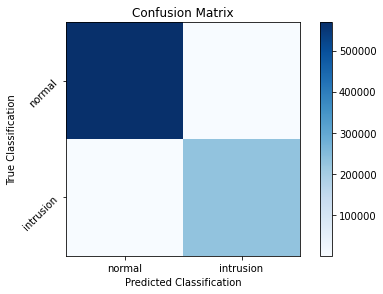

In [46]:
# compute confusion matrix
true_output = numpy.argmax(tf_output['test'].to_numpy(), axis=1)
cm = confusion_matrix(true_output, predicted)

# display confusion matrix values
display(pandas.DataFrame(cm, columns=tf_output['test'].columns, index=tf_output['test'].columns))
# display a confusion matrix visualization
pyplot.figure()
pyplot.imshow(cm, interpolation='nearest', cmap=pyplot.cm.Blues)
pyplot.title("Confusion Matrix")
pyplot.colorbar()
tick_marks = numpy.arange(len(tf_output['test'].columns))
pyplot.xticks(tick_marks, tf_output['test'].columns)
pyplot.yticks(tick_marks, tf_output['test'].columns, rotation=45)
pyplot.tight_layout()
pyplot.ylabel("True Classification")
pyplot.xlabel("Predicted Classification")
pyplot.show()

In [47]:
print(classification_report(true_output, predicted, digits=4, target_names=tf_output['test'].columns))

              precision    recall  f1-score   support

      normal     0.9997    0.9994    0.9995    569108
   intrusion     0.9985    0.9992    0.9988    231260

    accuracy                         0.9993    800368
   macro avg     0.9991    0.9993    0.9992    800368
weighted avg     0.9993    0.9993    0.9993    800368



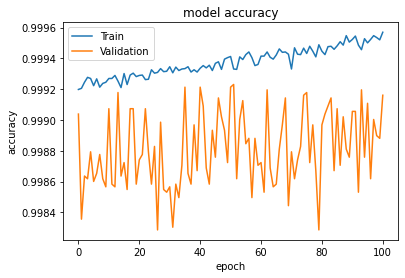

In [56]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


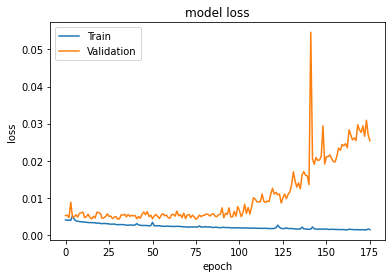

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()